In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np


import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some weights of BertForSequenceClassification were not initialized from the model")
warnings.filterwarnings("ignore", message="You should probably TRAIN this model on a down-stream task")

# Your code here
# Example:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Reset the warnings to default behavior after executing the code
warnings.resetwarnings()

In [2]:
def run_experiment(layer_name, layers_to_skip, num_samples, dataset_path="customer_support_tickets.csv"):
    print(f"\nRunning experiment: {layer_name}")
    
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv(dataset_path)
    data = data.dropna(subset=['Ticket Description'])
    data = data[['Ticket Description', 'Ticket Type']]
    
    # Sample data if not using the full dataset
    if num_samples == "full":
        data_subset = data
    else:
        data_subset = data.sample(n=num_samples, random_state=42)
    
    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['Ticket Description'], data_subset['Ticket Type'], test_size=0.2, random_state=42)
    
    # Encode labels
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Tokenization
    print("Tokenizing data...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

    # Convert encodings to a format suitable for the trainer
    print("Converting encodings to PyTorch Dataset format...")
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = MyDataset(train_encodings, train_labels_encoded)
    eval_dataset = MyDataset(test_encodings, test_labels_encoded)

    # Define BERT model
    print("Loading BERT model...")
    model_finetuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

    # Fine-tune by skipping intermediate layers
    if layers_to_skip == 'full':
        print("Not skipping any layers (training with all layers)...")
        model_pretrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    else:    
        print("Skipping specified layers...")
        encoder_layers = model_finetuned.bert.encoder.layer
        model_finetuned.bert.encoder.layer = torch.nn.ModuleList([layer for i, layer in enumerate(encoder_layers) if i in layers_to_skip])

        
    # Define training arguments
    print("Defining training arguments...")
    training_args = TrainingArguments(
        output_dir='./results_finetuned',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy='epoch',
        logging_dir='./logs_finetuned',
        num_train_epochs=3,
        learning_rate=2e-5,
        save_strategy='epoch',
        load_best_model_at_end=True
    )

    # Define trainer
    print("Initializing trainer...")
    trainer = Trainer(
        model=model_finetuned,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Train and evaluate model
    print("Training and evaluating model...")
    start_time = time.time()
    trainer.train()
    preds = trainer.predict(eval_dataset)
    processing_time = time.time() - start_time

    # Calculate metrics
    print("Calculating metrics...")
    accuracy = accuracy_score(test_labels_encoded, preds.predictions.argmax(axis=1))
    precision = precision_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    recall = recall_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    f1 = f1_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')

    # Print results
    print("Results for Layer:", layer_name)
    results_df = pd.DataFrame({'Layer Name': [layer_name], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1': [f1], 'Processing Time': [processing_time]})
    display(results_df)

    return results_df


In [22]:
# Example usage:
layers_to_skip = [
    np.random.choice(range(12), 6, replace=False),  # Random skipping
    np.random.choice(range(12), 6, replace=False),
    np.random.choice(range(12), 6, replace=False),
    [i for i in range(1, 12, 2)],  # Skipping odd layers
    [i for i in range(0, 12, 2)],  # Skipping even layers
    []  # No skipping (full pre-trained)
]
num_samples = 'full'  # Specify the number of samples, or "full" for the full dataset
results_dfs = []
display(layers_to_skip)
sorted_layers_to_skip = [ sorted(layer.tolist()) if isinstance(layer,np.ndarray) else layer for layer in layers_to_skip ]
display(sorted_layers_to_skip)
# Run experiments for each configuration
for layers in sorted_layers_to_skip:
    if len(layers) == 0:
        name = "Full_Pretrained"
        layers = 'full'
    else:
        name = "Layer_" + "_".join([ str(layer) for layer in layers]) + "_Skipped"
    results_df = run_experiment(name, layers, num_samples)
    results_dfs.append(results_df)

# Combine results into a single DataFrame
combined_results = pd.concat(results_dfs, ignore_index=True)
print("\nCombined Results:")
display(combined_results)

[array([10,  9,  0,  8,  5,  2]),
 array([10,  9,  0,  8,  6,  3]),
 array([ 7,  4, 10,  3,  1,  6]),
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 []]

[[0, 2, 5, 8, 9, 10],
 [0, 3, 6, 8, 9, 10],
 [1, 3, 4, 6, 7, 10],
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 []]


Running experiment: Layer_0_2_5_8_9_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.627600,1.614062
2,1.617300,1.610647
3,1.605200,1.612540


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_0_2_5_8_9_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.06081



Running experiment: Layer_0_3_6_8_9_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.626800,1.613622
2,1.618000,1.611240
3,1.609300,1.612937


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_0_3_6_8_9_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392



Running experiment: Layer_1_3_4_6_7_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.623000,1.610842
2,1.611800,1.610921
3,1.608300,1.610199


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_1_3_4_6_7_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_1_3_4_6_7_10_Skipped,0.20366,0.084385,0.20366,0.074252,6697.790006



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.620100,1.610638
2,1.613300,1.611135
3,1.604800,1.611037


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_1_3_5_7_9_11_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_1_3_5_7_9_11_Skipped,0.20366,0.041477,0.20366,0.068919,6702.326757



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.625800,1.613784
2,1.617800,1.611159
3,1.609600,1.613153


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Layer_0_2_4_6_8_10_Skipped


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_2_4_6_8_10_Skipped,0.208973,0.16101,0.208973,0.161536,6672.350841



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.618600,1.610432
2,1.611200,1.612422
3,1.607400,1.610444


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Calculating metrics...
Results for Layer: Full_Pretrained


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353



Combined Results:


,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757
4,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353


In [24]:
# Sort DataFrame based on F1 score
combined_results_sorted = combined_results.sort_values(by='F1', ascending=False)



In [25]:
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
4,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757


In [26]:
# Sort DataFrame based on Processing Time' score
combined_results_sorted = combined_results.sort_values(by='Processing Time', ascending=False)
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810
4,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841


In [27]:
# Sort DataFrame based on Processing Time' score
combined_results_sorted = combined_results.sort_values(by='Processing Time', ascending=True)
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Processing Time
4,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353


In [29]:
from datetime import timedelta
# Add a column for processing time in days, hours, minutes, and seconds format
combined_results_sorted['Processing Time (HOurs)'] = combined_results_sorted['Processing Time'].apply(lambda x: str(timedelta(seconds=x)))


In [30]:
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Processing Time,Processing Time (HOurs)
4,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841,1:51:12.350841
0,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810,1:51:18.060810
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006,1:51:37.790006
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757,1:51:42.326757
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392,1:51:50.654392
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353,4:37:26.342353


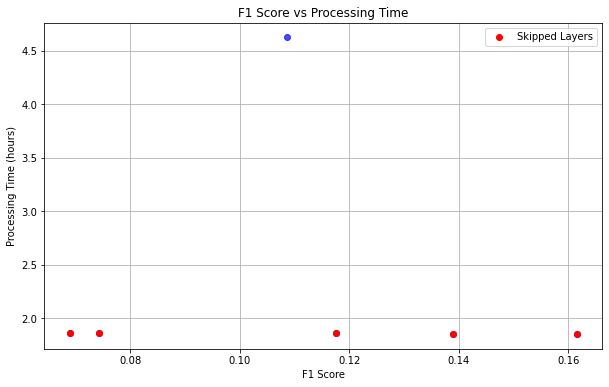

In [44]:
import matplotlib.pyplot as plt

# Data
f1_scores = combined_results_sorted['F1']
processing_time_hours = combined_results_sorted['Processing Time'] / 3600  # Convert processing time to hours
layer_names = combined_results_sorted['Layer Name']
skipped_layers = [layer_name.endswith("Skipped") for layer_name in layer_names]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(f1_scores, processing_time_hours, c='blue', alpha=0.7)
plt.scatter(f1_scores[skipped_layers], processing_time_hours[skipped_layers], c='red', label='Skipped Layers')
plt.title('F1 Score vs Processing Time')
plt.xlabel('F1 Score')
plt.ylabel('Processing Time (hours)')
plt.legend()
plt.grid(True)
plt.show()



In [51]:
combined_results_sorted.to_csv('Result_saved.csv',index=False)

In [52]:
df_loaded = pd.read_csv('Result_saved.csv')

In [53]:
df_loaded

,Layer Name,Accuracy,Precision,Recall,F1,Processing Time,Processing Time (HOurs)
0,Layer_0_2_4_6_8_10_Skipped,0.208973,0.161010,0.208973,0.161536,6672.350841,1:51:12.350841
1,Layer_0_2_5_8_9_10_Skipped,0.200708,0.187591,0.200708,0.138863,6678.060810,1:51:18.060810
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6697.790006,1:51:37.790006
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6702.326757,1:51:42.326757
4,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6710.654392,1:51:50.654392
5,Full_Pretrained,0.195986,0.077262,0.195986,0.108527,16646.342353,4:37:26.342353


In [54]:
!pwd

/Users/monu/Thesis_Apr29_2024


python(3910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
